# Tillage Classification Corn Model

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import time
import os
import PIL
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn
import pandas as pd
import copy
from collections import Counter

PHASES = ['train', 'val', 'test']


# Change to your own directory with train, val, and test as sub directories
DATA_DIR = "./corn_dataset"

# Path to save the model weight
MODEL_SAVE_PATH = "./saved_model_weights/corn_model_weight.pth"

## Data Transform (Resize)

In [2]:
# Data directory

# Data transformation
# For testing purpose, change val and test transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((576, 768), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((576, 768), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((576, 768), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
                  
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,
                                             shuffle=False, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=4,
                                             shuffle=False, num_workers=4)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train']

label_count = {x: image_datasets[x].targets for x in ['train', 'val', 'test']}
distribution = {x: list(Counter(image_datasets[x].targets).values()) for x in ['train', 'val', 'test']}

class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(label_count['train']), y=label_count['train'])
class_weights = torch.tensor(class_weights,dtype=torch.float)


classes = image_datasets['train'].classes
total_distribution = [distribution[x] for x in PHASES]
df_cm = pd.DataFrame(total_distribution, index=PHASES, columns=classes)
print(df_cm)
print("Class weights: ", class_weights)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Optional class weights experiements
class_weights = class_weights.to(device)

       grass  high_tillage  low_tillage  no_tillage
train     29            59          137          51
val        9            10           29          11
test       7             9           33          11
Class weights:  tensor([2.3793, 1.1695, 0.5036, 1.3529])


In [3]:
# Dataset Size Evaluation
train_size = len(image_datasets['train'])
val_size = len(image_datasets['val'])
test_size = len(image_datasets['test'])

print("There are %d data, %d used for training, %d used for validation, %d used for testing. " % (train_size + val_size + test_size, train_size, val_size, test_size))


There are 395 data, 276 used for training, 59 used for validation, 60 used for testing. 


## Image Show Function

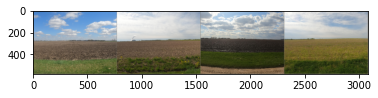

In [4]:
# Show Images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## Training function

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    val_losses = []
    train_losses = []

    val_acc = []
    train_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_losses, label="val")
    plt.plot(train_losses, label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(val_acc,label="val")
    plt.plot(train_acc,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training Process

### Load ResNet

In [6]:
# ResNet Model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Freeze the Batch Normalization
for module, param in zip(model_ft.modules(), model_ft.parameters()):
	if isinstance(module, nn.BatchNorm2d):
		param.requires_grad = False
        
# Add four classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

# Put to GPU
model_ft = model_ft.to(device)

# Loss Function
# criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
criterion = nn.CrossEntropyLoss()

# Adams Optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train

Epoch 0/49
----------
train Loss: 1.2634 Acc: 0.4601
val Loss: 1.1485 Acc: 0.4915

Epoch 1/49
----------
train Loss: 1.0727 Acc: 0.5254
val Loss: 0.9874 Acc: 0.3898

Epoch 2/49
----------
train Loss: 1.0434 Acc: 0.5290
val Loss: 1.2269 Acc: 0.5424

Epoch 3/49
----------
train Loss: 1.0986 Acc: 0.5217
val Loss: 1.4697 Acc: 0.2373

Epoch 4/49
----------
train Loss: 1.1509 Acc: 0.5072
val Loss: 1.1066 Acc: 0.5932

Epoch 5/49
----------
train Loss: 1.0930 Acc: 0.5036
val Loss: 0.9939 Acc: 0.5932

Epoch 6/49
----------
train Loss: 1.0824 Acc: 0.5326
val Loss: 1.8931 Acc: 0.3390

Epoch 7/49
----------
train Loss: 0.9846 Acc: 0.5833
val Loss: 0.8014 Acc: 0.5763

Epoch 8/49
----------
train Loss: 0.9487 Acc: 0.5725
val Loss: 0.7736 Acc: 0.6441

Epoch 9/49
----------
train Loss: 0.8984 Acc: 0.5978
val Loss: 0.7495 Acc: 0.6102

Epoch 10/49
----------
train Loss: 0.8435 Acc: 0.6014
val Loss: 0.6927 Acc: 0.6271

Epoch 11/49
----------
train Loss: 0.8302 Acc: 0.6268
val Loss: 0.6909 Acc: 0.7288

Ep

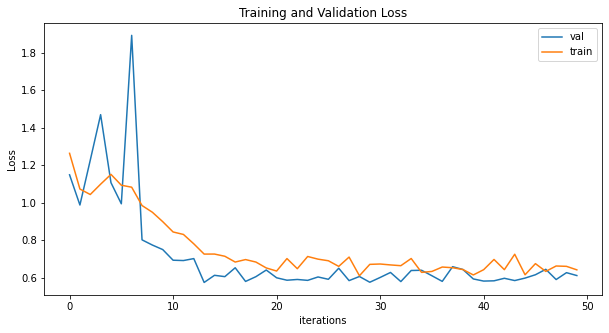

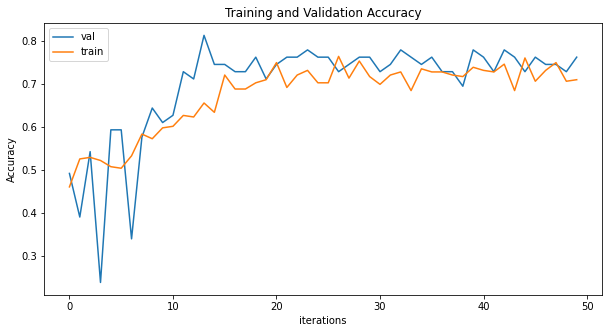

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

### Confusion Matrices

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders:
        output = model_ft(inputs.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
classes = ('grass', 'high_tillage', 'low_tillage', 'no_tillage')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame((cf_matrix.T/np.sum(cf_matrix, axis=1)).T, index = [i for i in classes],
                     columns = [i for i in classes])

ax = plt.axes()
print(df_cm)
ax.set_title('Confusion Matrix: Tillage Classification')
sn.heatmap(df_cm, ax=ax, annot=True)

## Save Model

In [8]:
torch.save(model_ft.state_dict(), MODEL_SAVE_PATH)